In [116]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder


data = pd.read_csv("../dataset/dataset1.csv")

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis (EDA)

### 1. Statistik Dasar Data Tiap Kolom/Fitur
#### Fitur Numerik


In [118]:
numeric_features = data.select_dtypes(include=[np.number])
numeric_stats = numeric_features.describe(percentiles=[.25, .5, .75]).T
numeric_stats

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


#### Fitur Kategorikal


In [119]:
categorical_features = data.select_dtypes(exclude=[np.number])
categorical_stats = categorical_features.describe().T
categorical_stats

,count,unique,top,freq
customerID,7043,7043,3186-AJIEK,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


Sebelum melanjutkan ke visualisasi distribusi setiap kolom, sedikit preprocessing lebih awal akan dikenakan pada fitur TotalCharges. Hal itu karena terjadi suatu keanehan terjadi dimana TotalCharges masuk kedalam Fitur Kategorikal

In [120]:
# Pengecekan nilai non-numeric di kolomTotalCharges
non_numeric_total_charges = data[~data['TotalCharges'].apply(lambda x: x.replace('.', '', 1).isdigit())]
non_numeric_total_charges

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Dari data yang ada, tampak bahwa kolom TotalCharges memiliki nilai kosong. Ini yang menyebabkan kolom tersebut terdeteksi sebagai fitur kategorikal.

In [121]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(data['TotalCharges'].isnull().sum())
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

11


#### Fitur Numerik Setelah Sedikit Reparasi

In [122]:
numeric_features = data.select_dtypes(include=[np.number])
numeric_stats = numeric_features.describe(percentiles=[.25, .5, .75]).T
numeric_stats

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.000,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80


#### Fitur Kategorikal Setelah Sedikit Reparasi

In [123]:
categorical_features = data.select_dtypes(exclude=[np.number])
categorical_features = categorical_features.drop(columns=['customerID'])
categorical_stats = categorical_features.describe().T
categorical_stats

,count,unique,top,freq
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095
TechSupport,7043,3,No,3473


### 2. Persebaran Data untuk Setiap Kolom/Fitur

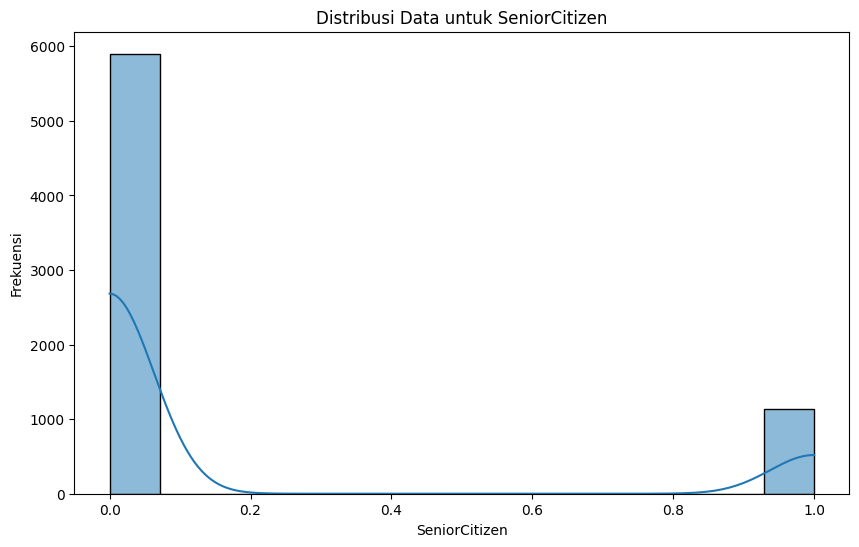

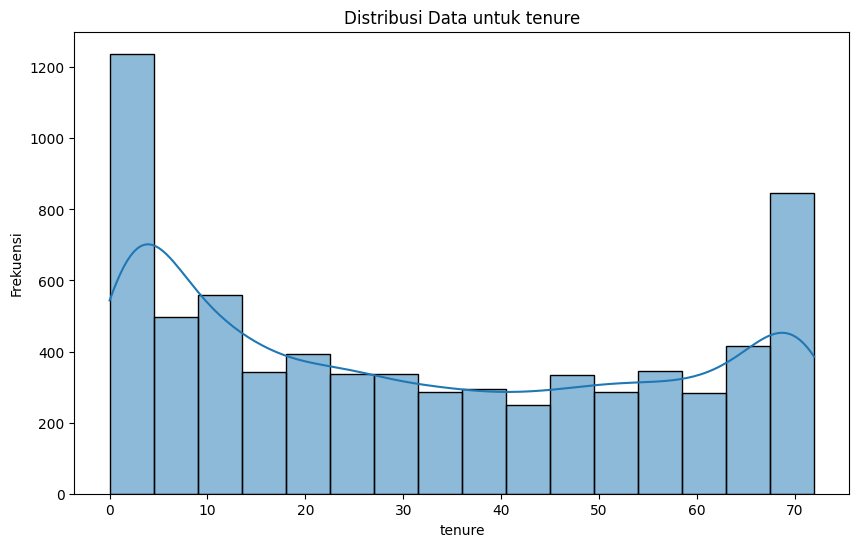

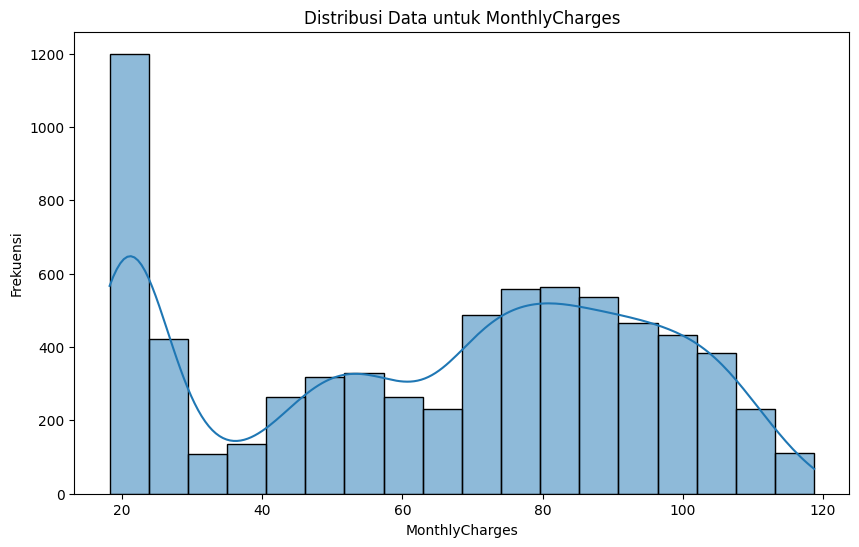

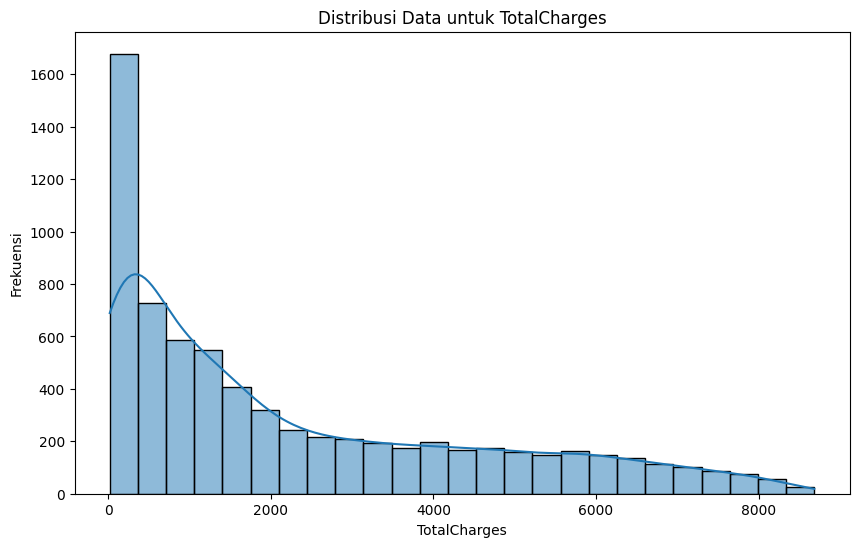

In [124]:
for column in numeric_features.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(numeric_features[column], kde=True)
    plt.title(f'Distribusi Data untuk {column}')
    plt.xlabel(column)
    plt.ylabel('Frekuensi')
    plt.show()

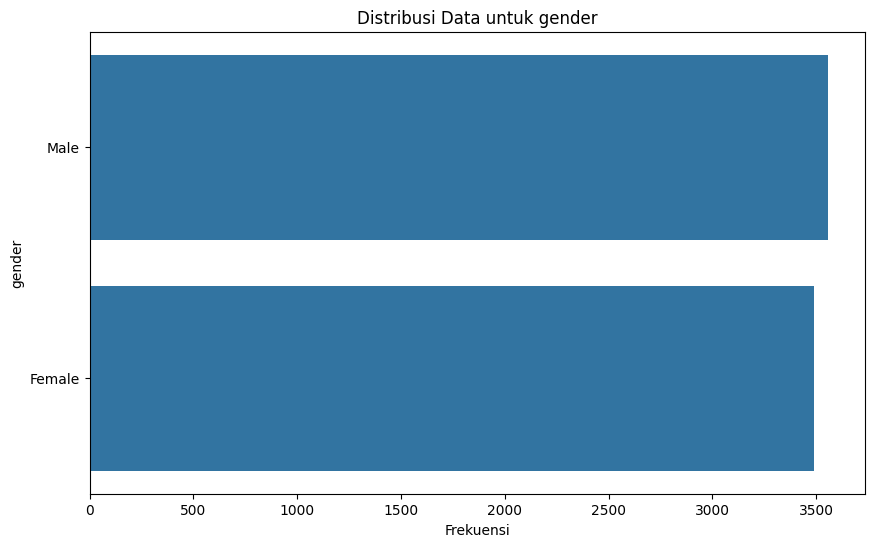

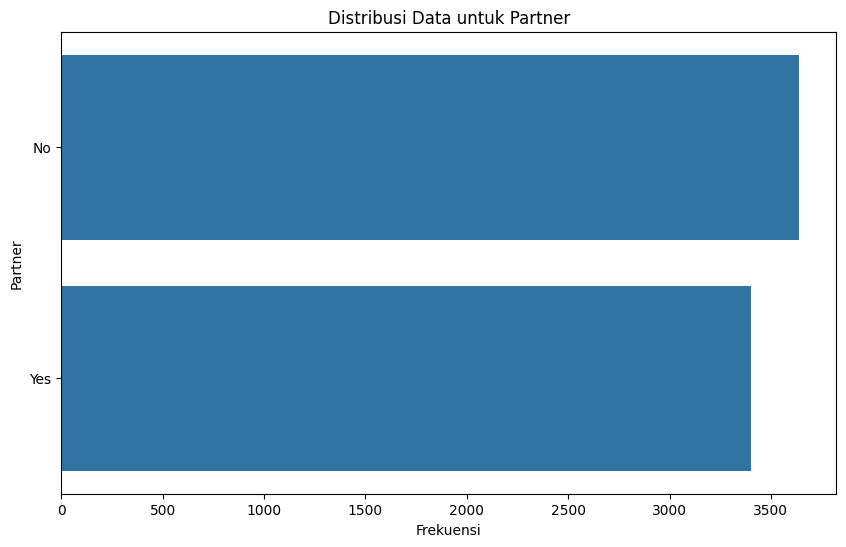

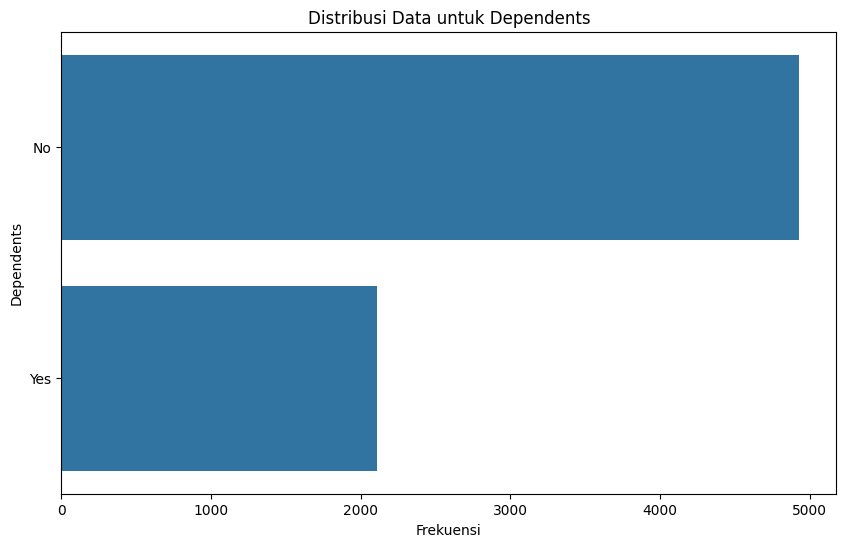

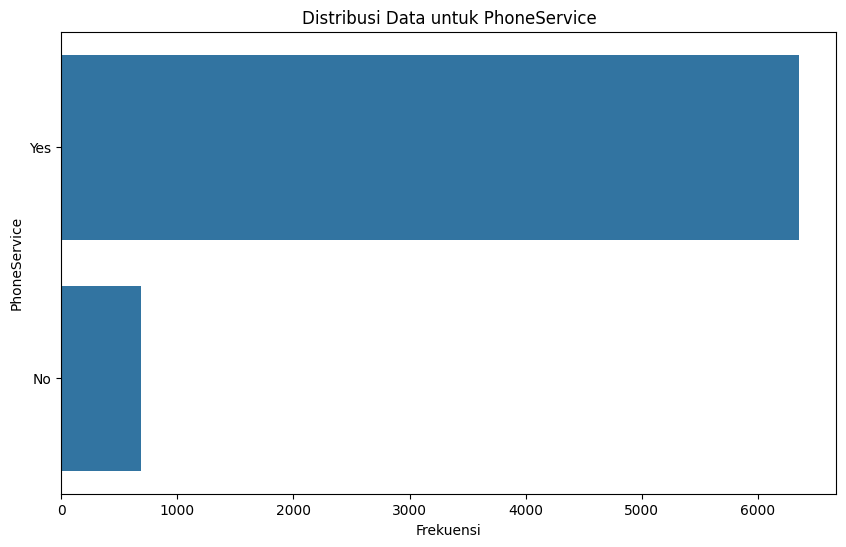

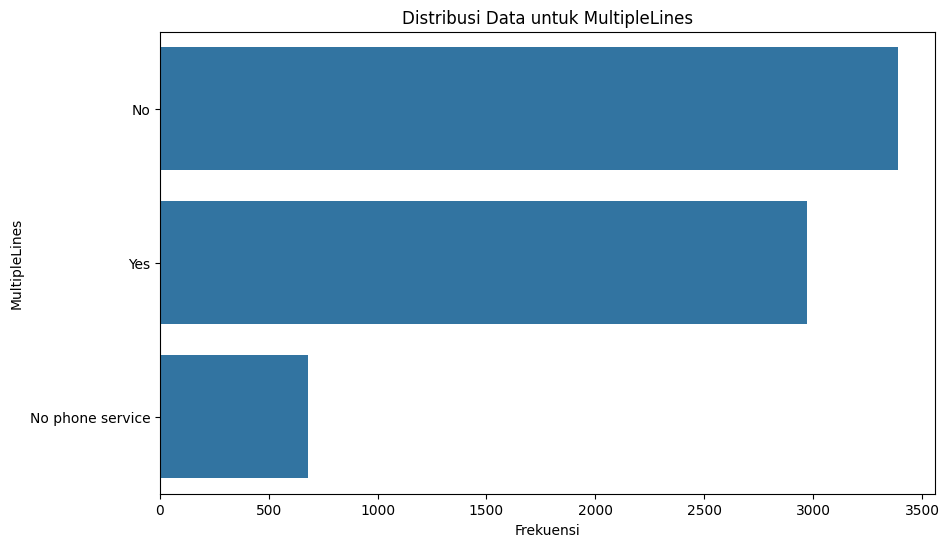

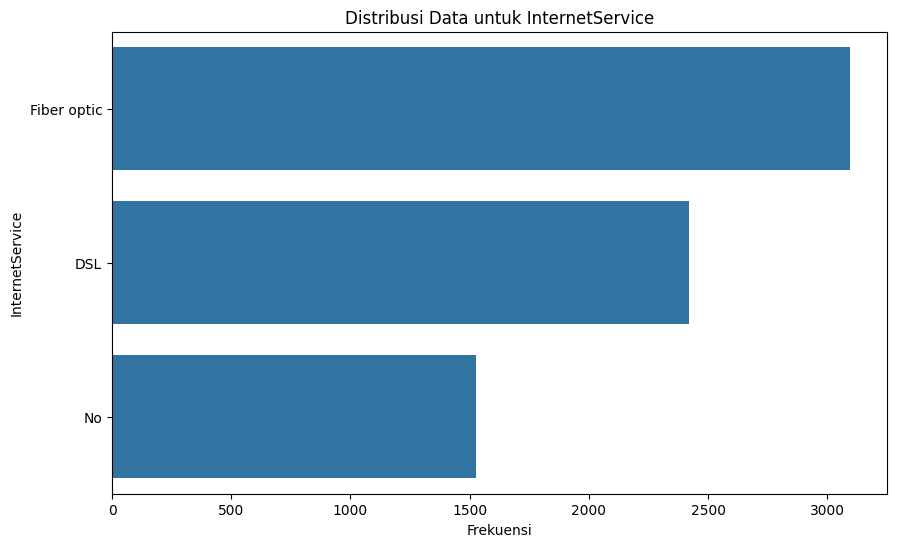

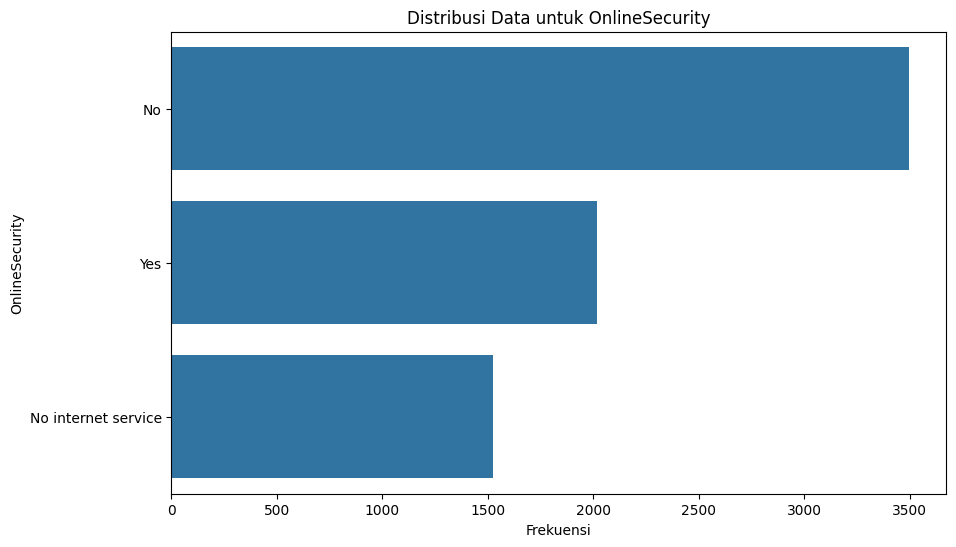

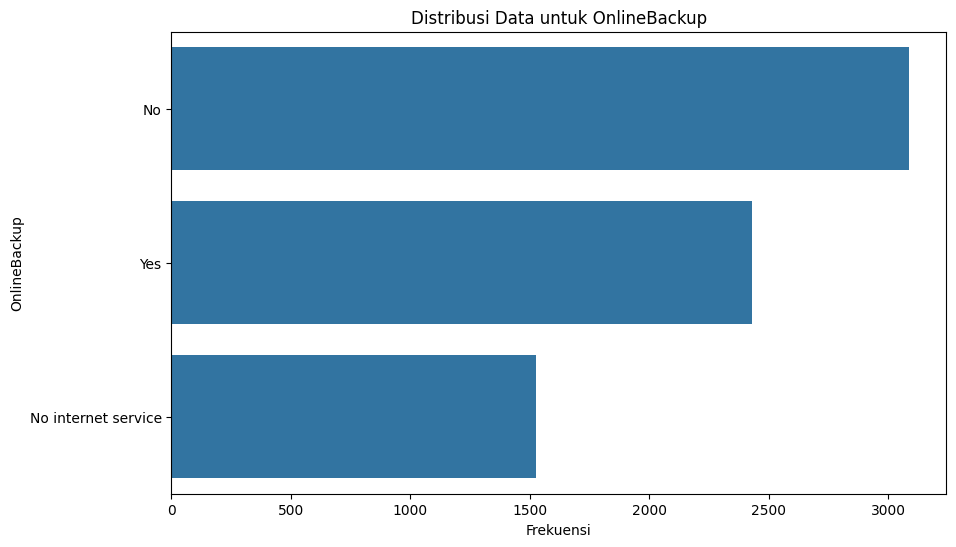

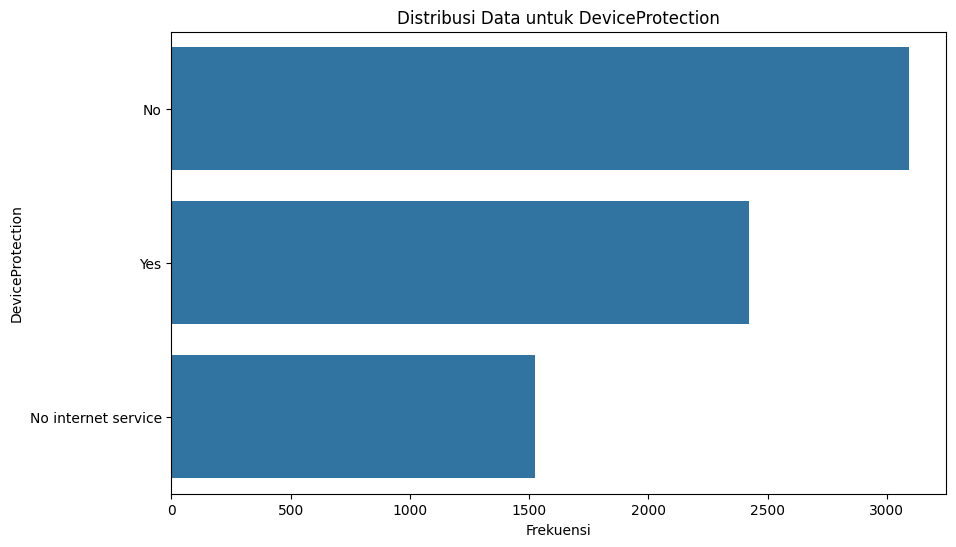

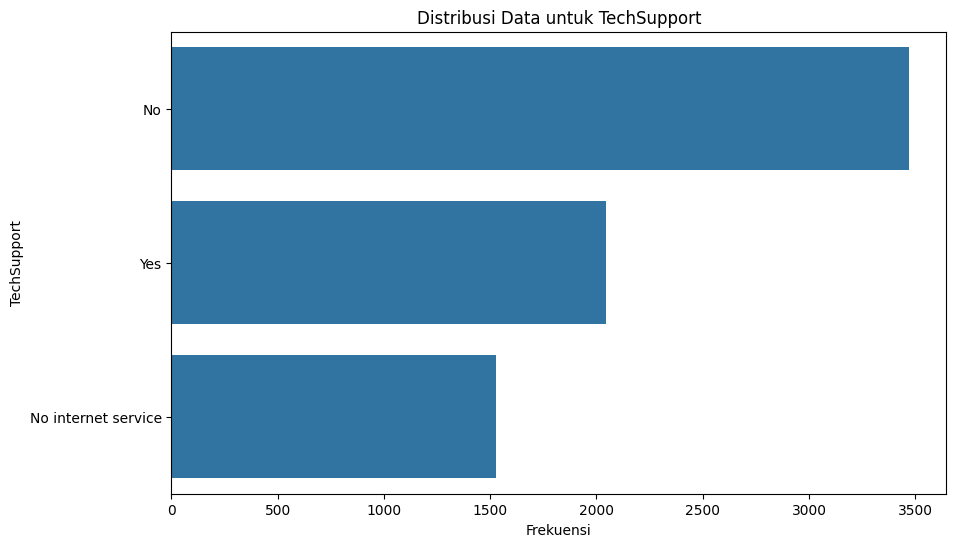

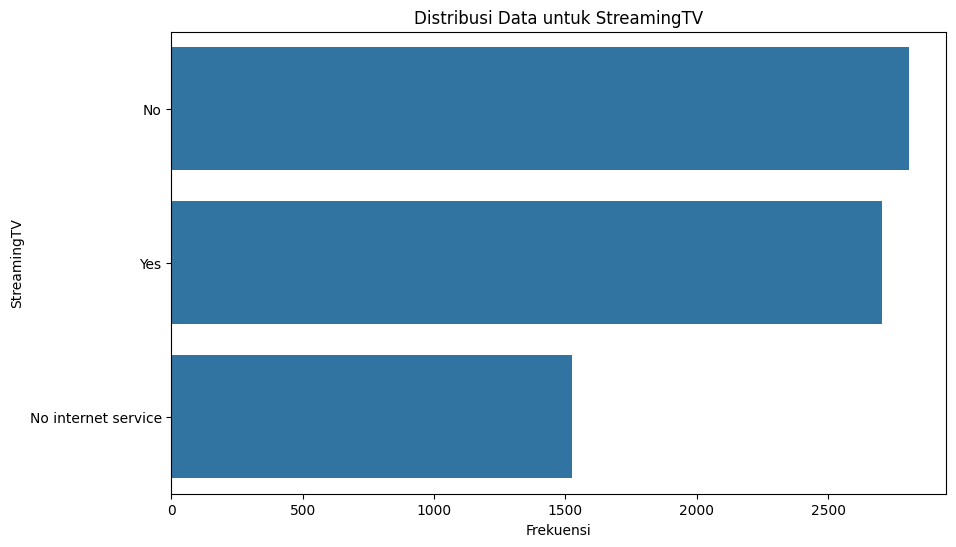

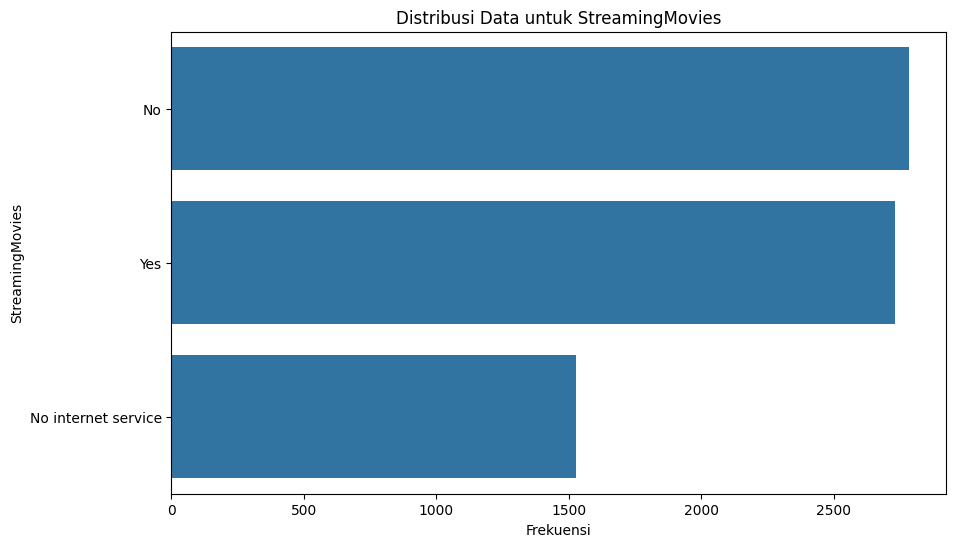

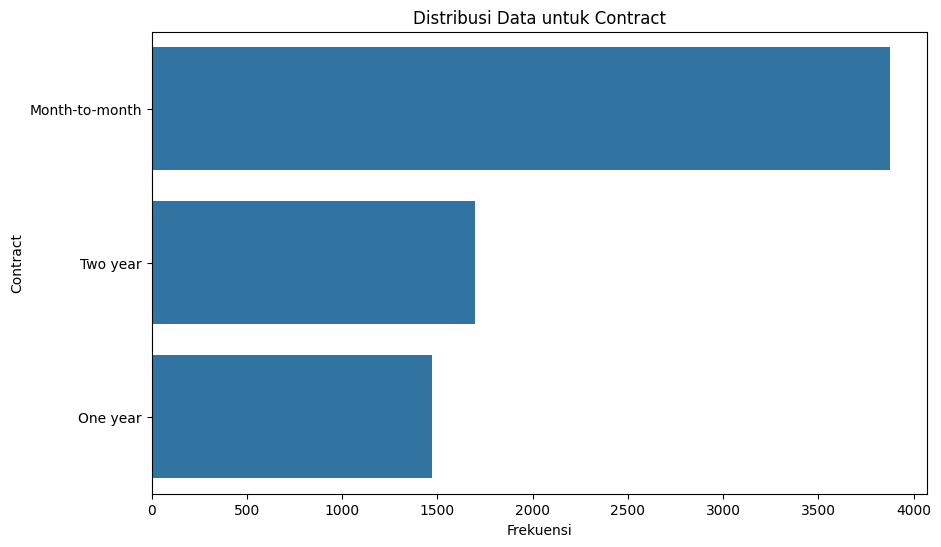

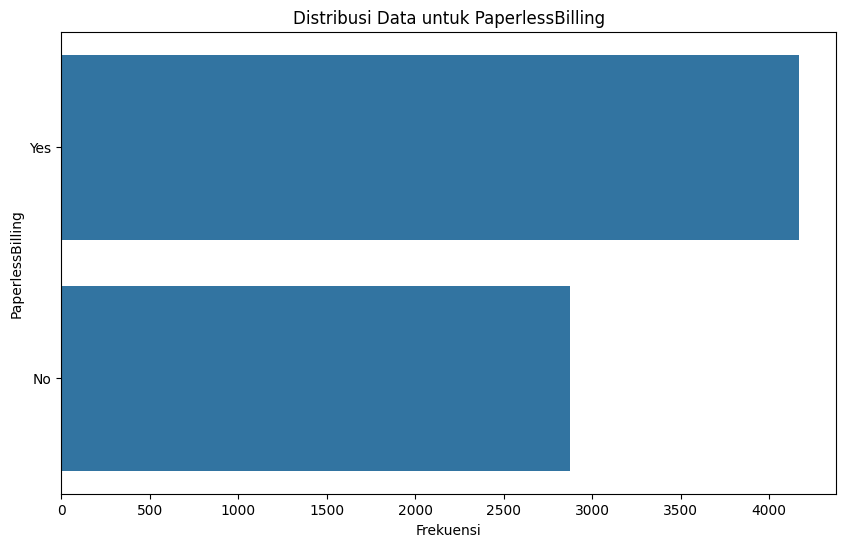

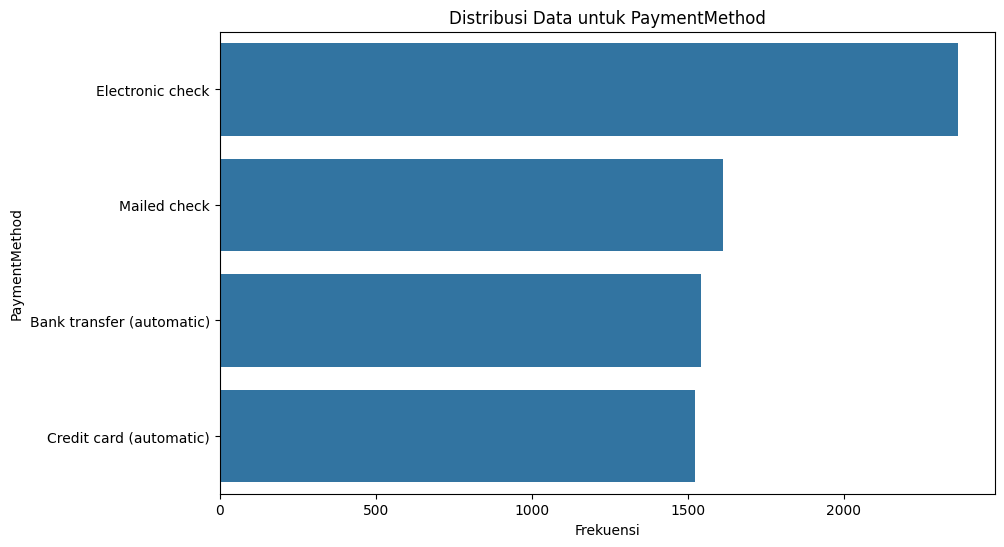

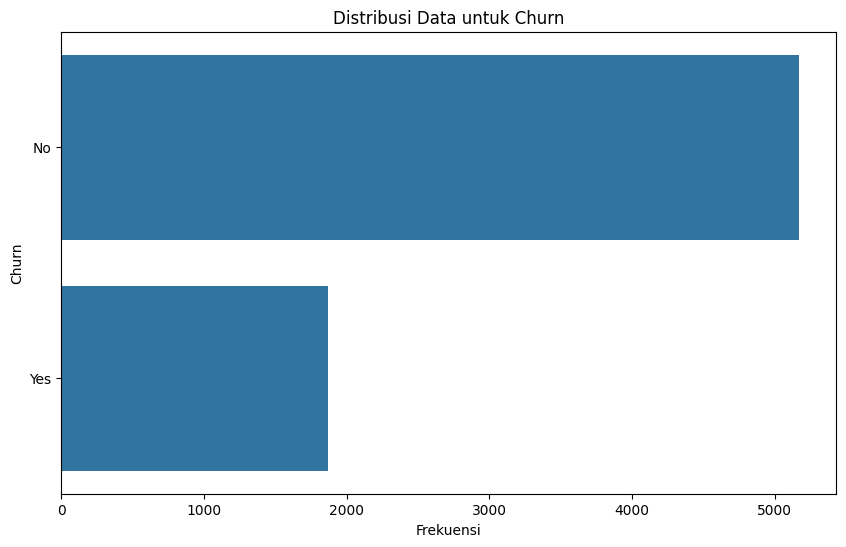

In [125]:
for column in categorical_features.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=categorical_features[column], order=categorical_features[column].value_counts().index)
    plt.title(f'Distribusi Data untuk {column}')
    plt.xlabel('Frekuensi')
    plt.ylabel(column)
    plt.show()

### 3. Pengecekan Outlier Menggunakan IQR


Analisis untuk tenure:
Jumlah outlier: 0
Persentase outlier: 0.00%


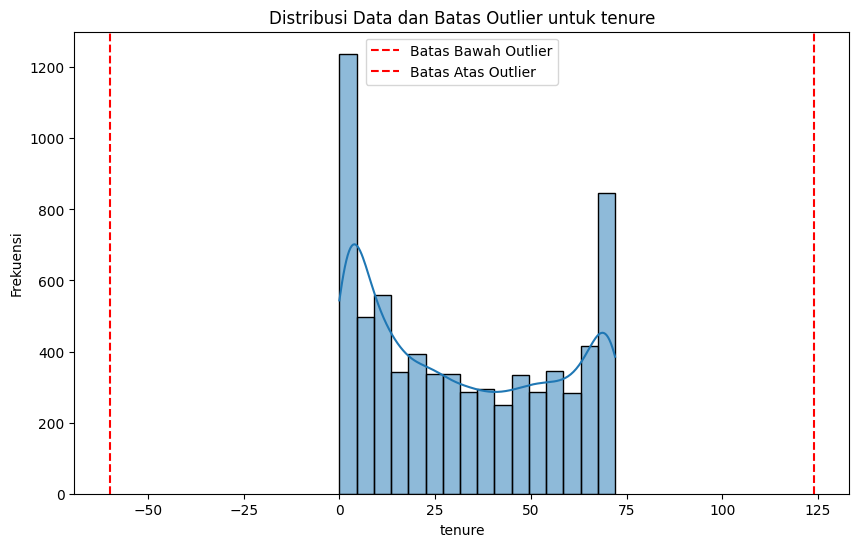


Analisis untuk MonthlyCharges:
Jumlah outlier: 0
Persentase outlier: 0.00%


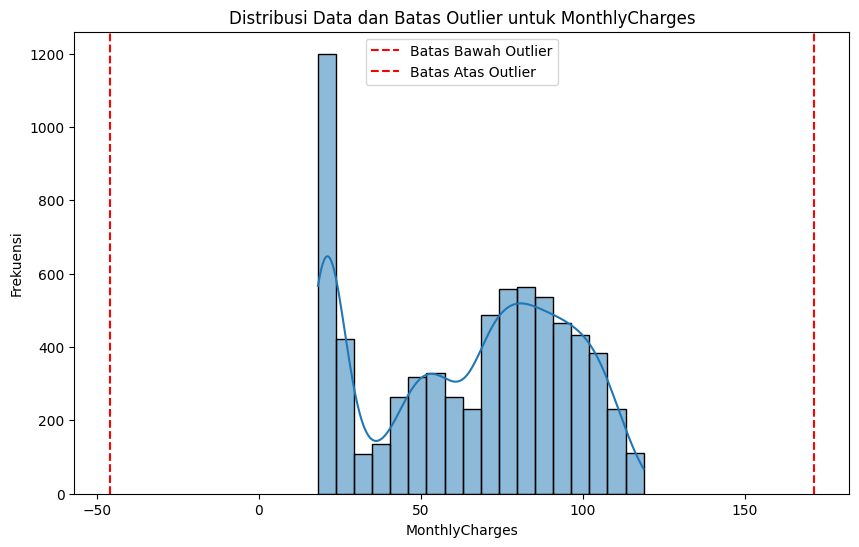


Analisis untuk TotalCharges:
Jumlah outlier: 0
Persentase outlier: 0.00%


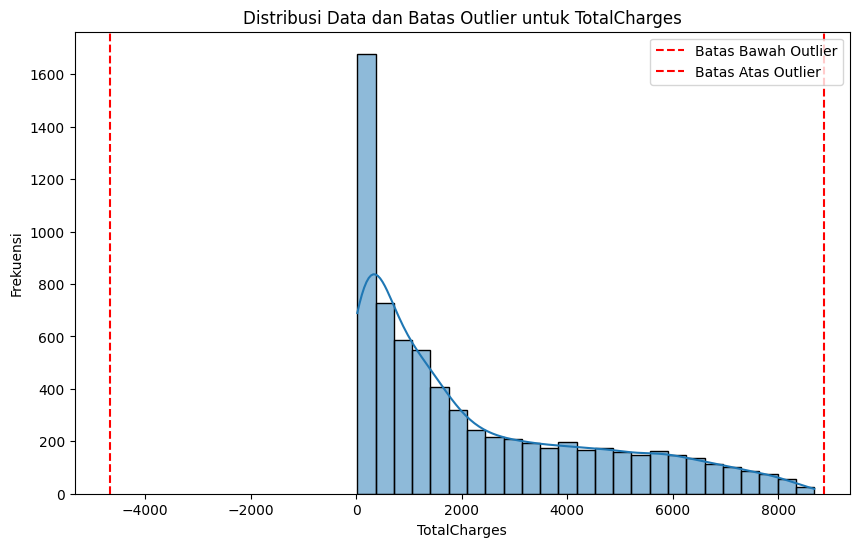

In [126]:
for column in numeric_features.columns:
    if column == "SeniorCitizen":
        continue

    Q1 = numeric_features[column].quantile(0.25)
    Q3 = numeric_features[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
        
    outliers = numeric_features[(numeric_features[column] < lower_bound) | (numeric_features[column] > upper_bound)]
        
    print(f"\nAnalisis untuk {column}:")
    print(f"Jumlah outlier: {len(outliers)}")
    print(f"Persentase outlier: {len(outliers) / len(numeric_features) * 100:.2f}%")
        
    # Visualisasi
    plt.figure(figsize=(10, 6))
    sns.histplot(numeric_features[column], kde=True)
    plt.axvline(lower_bound, color='r', linestyle='--', label='Batas Bawah Outlier')
    plt.axvline(upper_bound, color='r', linestyle='--', label='Batas Atas Outlier')
    plt.title(f'Distribusi Data dan Batas Outlier untuk {column}')
    plt.xlabel(column)
    plt.ylabel('Frekuensi')
    plt.legend()
    plt.show()


### 4. Matriks Korelasi

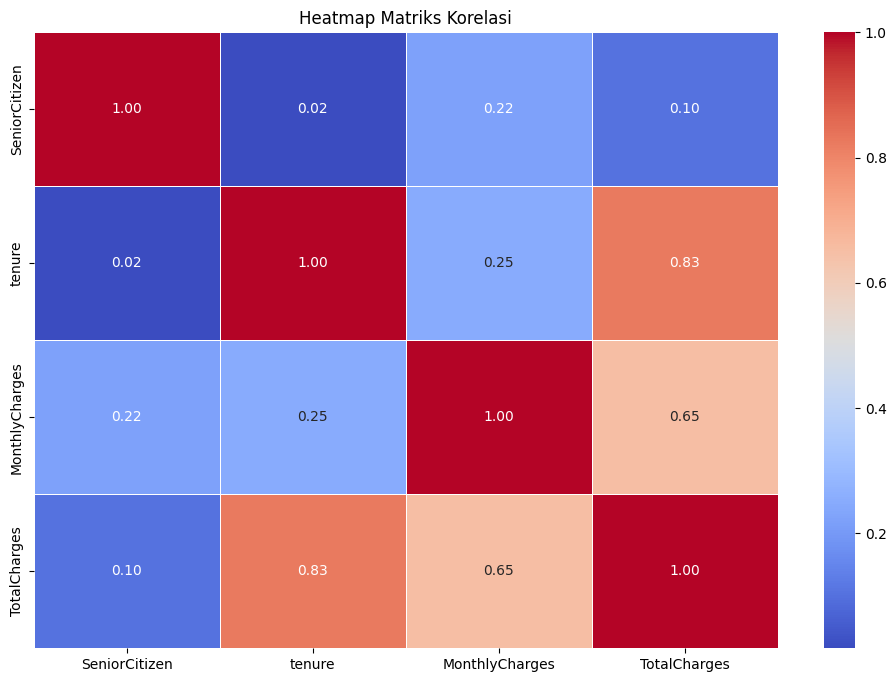

In [127]:
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap Matriks Korelasi')
plt.show()

### 5. Missing Values

In [128]:
missing_values = data.isnull().sum()
print("Missing Values per Kolom:")
print(missing_values)

Missing Values per Kolom:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### 6. Pengecekan Inkonsistensi

In [129]:
for column in categorical_features:
    print(f'{column}: {data[column].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


## Data Preprocessing

### 1. Penghapusan Fitur dengan Korelasi Tinggi

Berdasarkan matriks korelasi, fitur TotalCharges memiliki korelasi yang tinggi dengan fitur tenure (0.83) dan MonthlyCharges (0.65). Oleh karena itu penghapusan dapat dikenakan terhadap fitur TotalCharges untuk mengurangi redundansi informasi, menyederhanakan dan mengurangi risiko overfitting

In [130]:
data = data.drop(columns="TotalCharges")
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,Yes


In [131]:
numeric_features = numeric_features.drop(columns="TotalCharges")
numeric_features

,SeniorCitizen,tenure,MonthlyCharges
0,0,1,29.85
1,0,34,56.95
2,0,2,53.85
3,0,45,42.30
4,0,2,70.70
...,...,...,...
7038,0,24,84.80
7039,0,72,103.20
7040,0,11,29.60
7041,1,4,74.40


### 2. Menghapus Baris Duplikat

Sebenarnya, kemungkinan adanya baris duplikat pada dataset ini cukup kecil. Akan tetapi, untuk berjaga-jaga, kode untuk menghapus baris duplikat tetap harus dijalankan. Baris duplikat dihapus dengan tujuan untuk mengurangi redundansi

In [132]:
data = data.drop_duplicates()

### 3. Memperbaiki Error dan Inkonsistensi

Berdasarkan hasil pemeriksaan inkonsistensi, dapat dilihat bahwa beberapa kolom memiliki kategori khusus seperti 'No phone service' atau 'No internet service'. Perbaikan perlu dilakukan untuk menjaga konsistensi dan memudahkan analisis lebih lanjut

In [133]:
data['MultipleLines'] = data['MultipleLines'].replace({'No phone service': 'No'})
data['OnlineSecurity'] = data['OnlineSecurity'].replace({'No internet service': 'No'})
data['OnlineBackup'] = data['OnlineBackup'].replace({'No internet service': 'No'})
data['DeviceProtection'] = data['DeviceProtection'].replace({'No internet service': 'No'})
data['TechSupport'] = data['TechSupport'].replace({'No internet service': 'No'})
data['StreamingTV'] = data['StreamingTV'].replace({'No internet service': 'No'})
data['StreamingMovies'] = data['StreamingMovies'].replace({'No internet service': 'No'})

for column in categorical_features:
    print(f'{column}: {data[column].unique()}')


gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


### 4. Normalisasi


Normalisasi dilakukan untuk memastikan bahwa semua feature berada pada skala yang sama, sehingga dapat membantu algoritma machine learning berfungsi lebih baik dan konvergen lebih cepat. Ini juga membantu dalam mengurangi bias dalam feature yang memiliki rentang nilai yang lebih besar.

In [134]:
scaler = StandardScaler()
data['MonthlyCharges'] = scaler.fit_transform(data[['MonthlyCharges']])
data['tenure'] = scaler.fit_transform(data[['tenure']])

### 5. Encoding Feature Kategorikal

Model machine learning tidak bisa bekerja langsung dengan data kategori, sehingga fitur kategori perlu diubah menjadi format numerik. Label Encoding digunakan untuk fitur dengan dua kategori untuk menghindari urutan yang tidak semestinya, sedangkan One-Hot Encoding digunakan untuk fitur dengan lebih dari dua kategori untuk memastikan setiap kategori diwakili sebagai kolom biner yang terpisah, sehingga tidak ada urutan atau prioritas yang diberikan pada kategori-kategori tersebut.

In [ ]:
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                        'PaperlessBilling', 'PaymentMethod', 'Churn']

label_enc = LabelEncoder()
for feature in categorical_features:
    if data[feature].nunique() == 2:
        data[feature] = label_enc.fit_transform(data[feature])

data = pd.get_dummies(data, columns=[feature for feature in categorical_features if data[feature].nunique() > 2])